In [8]:
import random
from collections import deque
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class DQN(nn.Module):
    """ 深度Q网络 """
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),  # 如果batch size为1，则使用LayerNorm
            nn.LeakyReLU(0.01),   # 负斜率为0.01

            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.LeakyReLU(0.01),

            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.01),

            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.01),

            nn.Linear(64, 32),
            nn.LayerNorm(32),
            nn.LeakyReLU(0.01),

            nn.Linear(32, output_dim)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                # 使用He初始化 (LeakyReLU)
                nn.init.kaiming_normal_(m.weight, a=0.01, mode='fan_in', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # 输出层的初始化可以单独设置，但通常不需要特别设置

    def forward(self, x):
        return self.net(x)


class PrioritizedReplayBuffer():
    """ 优先级经验回放缓冲区 """
    def __init__(self, capacity, alpha=0.6, beta=0.4, beta_increment=0.001):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
        self.priorities = deque(maxlen=capacity)
        self.alpha = alpha  # 优先级指数
        self.beta = beta    # 重要性采样权重
        self.beta_increment = beta_increment
        self.max_priority = 1.0  # 初始最大优先级
        self.position = 0
    
    def __len__(self):
        return len(self.buffer)
    
    def push(self, state, action, reward, next_state, done):
        # 新样本初始优先级设为当前最大优先级
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
            self.priorities.append(None)
        
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.capacity
    
    def get_batch(self, batch_size):
        # 计算采样概率
        priorities = np.array(self.priorities, dtype=np.float32)
        probs = priorities ** self.alpha
        probs /= probs.sum()
        
        # 采样索引
        indices = np.random.choice(len(self.buffer), batch_size, p=probs)
        
        # 计算重要性采样权重
        weights = (len(self.buffer) * probs[indices]) ** (-self.beta)
        weights /= weights.max()  # 归一化
        
        # 更新beta
        self.beta = min(1.0, self.beta + self.beta_increment)
        
        # 获取样本
        batch = [self.buffer[i] for i in indices]
        states = [item[0] for item in batch]
        actions = [item[1] for item in batch]
        rewards = [0.0 if r is None else r for _, _, r, _, _ in batch]
        next_states = [item[3] for item in batch]
        dones = [item[4] for item in batch]
        
        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.float32),
            indices,
            np.array(weights, dtype=np.float32)
        )
    
    def update_priorities(self, indices, priorities):
        """更新样本优先级"""
        for idx, priority in zip(indices, priorities):
            self.priorities[idx] = priority
            if priority > self.max_priority:
                self.max_priority = priority


class DQNAgent():
    """ 包含经验回放和目标网络的DQN智能体 """
    def __init__(self, input_dim, action_dim, device=None):
        # 直接接收输入维度和动作维度
        self.input_dim = input_dim
        self.action_dim = action_dim
        
        # 设置计算设备
        self.device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # 超参数
        self.gamma = 0.95   # 折扣因子
        self.lr = 0.0005
        self.epsilon_start = 1.0
        self.epsilon_end = 0.05
        self.epsilon_decay = 0.99996 
        self.batch_size = 256
        self.sync_interval = 20  # 目标网络更新频率
        self.buffer_capacity = 30000
        self.update_frequency = 1  # 每5步更新一次网络
        
        # 网络和优化器
        self.online_net = DQN(self.input_dim, self.action_dim).to(self.device)
        self.target_net = DQN(self.input_dim, self.action_dim).to(self.device)
        self.target_net.load_state_dict(self.online_net.state_dict())
        self.target_net.eval()  # 目标网络不计算梯度
        
        self.optimizer = optim.Adam(self.online_net.parameters(), lr=self.lr)
        
        # 添加学习率调度器
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, 
            mode='min', 
            factor=0.2, 
            min_lr=1e-6,
            patience=20, 
            verbose=True
        )
        
        # 使用优先级经验回放缓冲区
        self.replay_buffer = PrioritizedReplayBuffer(self.buffer_capacity)
        
        # 训练参数
        self.epsilon = self.epsilon_start
    
    def get_action(self, state):
        """ ε-greedy策略选择动作，带衰减 """
        self.epsilon = max(self.epsilon_end, self.epsilon * self.epsilon_decay)  # 指数衰减
        
        if random.random() < self.epsilon:
            return random.randint(0, self.action_dim - 1)   # 随机探索
        else:
            with torch.no_grad():
                # 确保输入张量形状正确
                state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)
                q_values = self.online_net(state_tensor)
                return q_values.argmax().item()   # 选择最优动作
    
    def get_greedy_action(self, state):
        """获取贪婪策略下的动作（用于评估）"""
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).to(self.device).unsqueeze(0)
            q_values = self.online_net(state_tensor)
            return q_values.argmax().item()
    
    def sync_target_net(self):
        """ 更新目标网络 """
        self.target_net.load_state_dict(self.online_net.state_dict())
    
    def update(self):
        """ 使用优先级经验回放更新网络 """
        if len(self.replay_buffer) < self.batch_size:
            return 0, 0  # 返回损失和平均优先级
        
        # 从缓冲区采样（包含权重）
        states, actions, rewards, next_states, dones, indices, weights = self.replay_buffer.get_batch(self.batch_size)
        
        # 转换为张量并移至设备
        states = torch.FloatTensor(states).to(self.device)
        actions = torch.LongTensor(actions).to(self.device)
        rewards = torch.FloatTensor(rewards).to(self.device)
        next_states = torch.FloatTensor(next_states).to(self.device)
        dones = torch.FloatTensor(dones).to(self.device)
        weights = torch.FloatTensor(weights).to(self.device)
        
        # 计算当前Q值
        current_q_values = self.online_net(states)
        # 使用gather获取选择的动作对应的Q值
        current_q = current_q_values.gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # 计算目标Q值（使用目标网络）
        with torch.no_grad():
            next_q_values = self.target_net(next_states)
            # 计算最大Q值
            max_next_q = next_q_values.max(1)[0]
            # 计算目标值
            target_q = rewards + (1 - dones) * self.gamma * max_next_q
        
        # 计算TD误差（用于优先级）
        td_errors = target_q - current_q
        
        # 计算损失（改为MSE损失）
        # 原代码: loss = F.smooth_l1_loss(current_q, target_q, reduction='none')
        loss = F.mse_loss(current_q, target_q, reduction='none')
        loss = (loss * weights).mean()
        
        # 优化
        self.optimizer.zero_grad()
        loss.backward()
        
        # 梯度裁剪防止梯度爆炸
        torch.nn.utils.clip_grad_norm_(self.online_net.parameters(), max_norm=1.0)
        
        self.optimizer.step()
        
        # 更新学习率
        self.scheduler.step(loss)
        
        # 更新缓冲区优先级
        priorities = td_errors.detach().abs().cpu().numpy() + 1e-5  # 避免零优先级
        self.replay_buffer.update_priorities(indices, priorities)
        
        return loss.item(), priorities.mean()


def enhanced_one_hot_encode(state, height, width, goal_state):
    """ 增强状态表示 - 包含目标方向信息和相对位置 """
    base_dim = height * width
    vec = np.zeros(base_dim + 6, dtype=np.float32)  # +6 表示额外特征
    
    # 基础状态编码
    row, col = state
    vec[row * width + col] = 1
    
    # 添加目标位置信息
    goal_row, goal_col = goal_state
    
    # 相对位置特征
    vec[base_dim] = (col - goal_col) / width  # 水平相对位置
    vec[base_dim + 1] = (row - goal_row) / height  # 垂直相对位置
    
    # 方向特征
    if col < goal_col:
        vec[base_dim + 2] = 1  # 目标在右侧
    elif col > goal_col:
        vec[base_dim + 3] = 1  # 目标在左侧
    
    if row < goal_row:
        vec[base_dim + 4] = 1  # 目标在上方
    elif row > goal_row:
        vec[base_dim + 5] = 1  # 目标在下方
    
    return vec


In [9]:
import os, sys, time

if not os.path.exists(traning_data_root):
    os.makedirs(traning_data_root)

if "common_expand" not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "common_expand"))

from common_expand.gridworld import GridWorld

# 创建网格世界环境
env = GridWorld()
height, width = env.height, env.width

# 计算增强状态的维度
base_dim = height * width
state_dim = base_dim + 6  # 基础状态 + 6个方向特征

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device.type.upper()}")

# 创建智能体 - 使用正确的输入维度
agent = DQNAgent(input_dim=state_dim, action_dim=len(env.action_space), device=device)

# 训练参数
episodes = 2000
avg_episode = episodes // 20

# 保存位置
traning_data_root = "./data_DQN_optim2"

rewards_history = []   # 记录每回合的奖励
loss_history = []      # 记录损失函数
epsilon_history = []   # 记录ε值的衰减
steps_history = []     # 记录完成每回合的步数
priority_history = []  # 记录优先级平均值
training_data_file = os.path.join(traning_data_root, "dqn_train_data.csv")

# 开始时间
start_time = time.time()

# 训练过程
for episode in range(episodes):
    # 重置环境并获取增强状态
    raw_state = env.reset()
    state = enhanced_one_hot_encode(raw_state, height, width, env.goal_state)
    
    episode_loss = list()
    total_reward = 0
    done = False
    step_count = 0
    max_steps = 300
    
    while not done and step_count < max_steps:        
        # 选择并执行动作
        action = agent.get_action(state)
        raw_next_state, reward, done = env.step(action)
        next_state = enhanced_one_hot_encode(raw_next_state, height, width, env.goal_state)
        
        # 存储经验
        agent.replay_buffer.push(state, action, reward, next_state, done)
        
        # 定期更新网络
        if step_count % agent.update_frequency == 0 and len(agent.replay_buffer) >= agent.batch_size:
            loss, avg_priority = agent.update()
            if loss > 0:  # 只记录有效的损失值
                episode_loss.append(loss)
                priority_history.append(avg_priority)
        
        # 定期更新目标网络
        if step_count % agent.sync_interval == 0:
            agent.sync_target_net()
        
        state = next_state
        total_reward += reward
        step_count += 1
    
    if episode+1 == 500:
        print("添加惩罚状态 (12, 16): -1.0")
        env.add_pits((12, 16))

    # 记录
    rewards_history.append(total_reward)
    epsilon_history.append(agent.epsilon)
    steps_history.append(step_count)
    avg_loss = np.mean(episode_loss) if episode_loss else 0.0
    loss_history.append(avg_loss)

    # 保存训练数据
    if not os.path.exists(training_data_file):
        os.makedirs(os.path.dirname(training_data_file), exist_ok=True)
        with open(training_data_file, "w") as f:
            f.write("episode,total_reward,step_count,loss,epsilon,priority\n")
    
    with open(training_data_file, "a") as f:
        avg_priority = priority_history[-1] if priority_history else 0
        f.write(f"{episode},{total_reward},{step_count},{avg_loss},{agent.epsilon},{avg_priority}\n")
    
    # 打印训练进度
    if episode % avg_episode == 0 or episode == episodes - 1:
        # 计算最近avg_episode个episode的平均奖励
        window_size = min(avg_episode, len(rewards_history))
        avg_reward = np.mean(rewards_history[-window_size:]) if window_size > 0 else 0
        
        # 计算最近avg_episode次更新的平均损失
        window_size = min(avg_episode, len(loss_history))
        avg_loss = np.mean(loss_history[-window_size:]) if window_size > 0 else 0
        
        print(f"Episode {episode:4d}, Reward: {total_reward:6.2f}, "
                f"Epsilon: {agent.epsilon:.4f}, "
                f"Avg Reward ({avg_episode}): {avg_reward:6.2f}, "
                f"Avg Loss: {avg_loss:.4f}")

duration_time = time.time() - start_time

# 训练结束后保存最终模型
torch.save({
    'online_net_state_dict': agent.online_net.state_dict(),
    'target_net_state_dict': agent.target_net.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
    'episode': episode,
    'rewards_history': rewards_history,
    'loss_history': loss_history
}, os.path.join(traning_data_root, 'dqn_gridworld_model_final.pth'))

print(f"Training completed! Model saved, duration time: {duration_time:.2f}s.")

Training on: CUDA


d:\ProgramDev\py_envs\rl_pyenv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Episode    0, Reward:   0.00, Epsilon: 0.9881, Avg Reward (100):   0.00, Avg Loss: 0.0319
Episode  100, Reward:   2.00, Epsilon: 0.4029, Avg Reward (100):   0.18, Avg Loss: 0.0002
Episode  200, Reward:   2.00, Epsilon: 0.3205, Avg Reward (100):   1.97, Avg Loss: 0.0002
Episode  300, Reward:   2.00, Epsilon: 0.2649, Avg Reward (100):   2.00, Avg Loss: 0.0001
Episode  400, Reward:   2.00, Epsilon: 0.2225, Avg Reward (100):   2.00, Avg Loss: 0.0000
添加惩罚状态 (12, 16): -1.0
Episode  500, Reward:   2.00, Epsilon: 0.1863, Avg Reward (100):   2.00, Avg Loss: 0.0000
Episode  600, Reward:   2.00, Epsilon: 0.1585, Avg Reward (100):   2.00, Avg Loss: 0.0000
Episode  700, Reward:   2.00, Epsilon: 0.1359, Avg Reward (100):   2.00, Avg Loss: 0.0000
Episode  800, Reward:   2.00, Epsilon: 0.1167, Avg Reward (100):   2.00, Avg Loss: 0.0000
Episode  900, Reward:   2.00, Epsilon: 0.1006, Avg Reward (100):   2.00, Avg Loss: 0.0000
Episode 1000, Reward:   2.00, Epsilon: 0.0871, Avg Reward (100):   2.00, Avg L

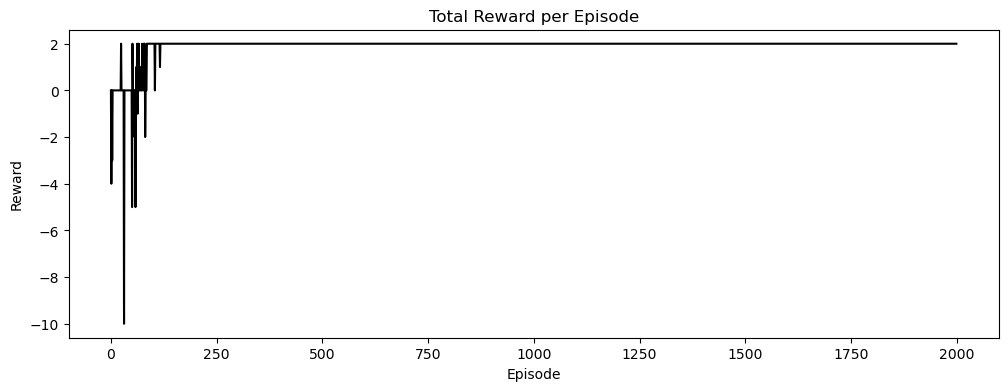

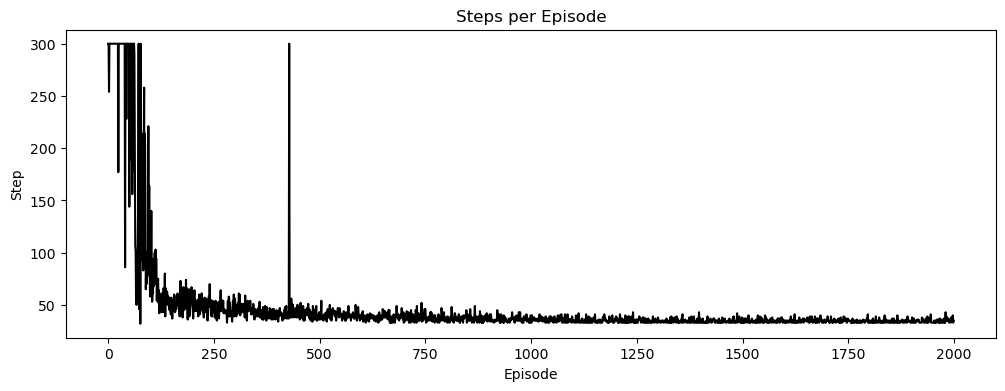

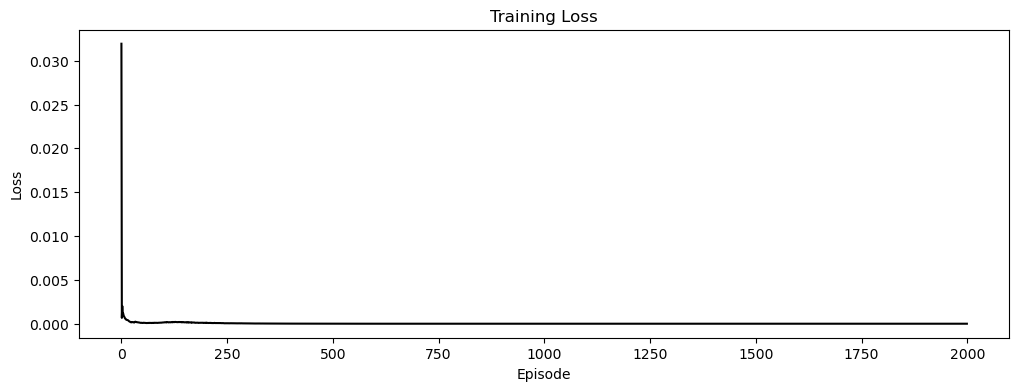

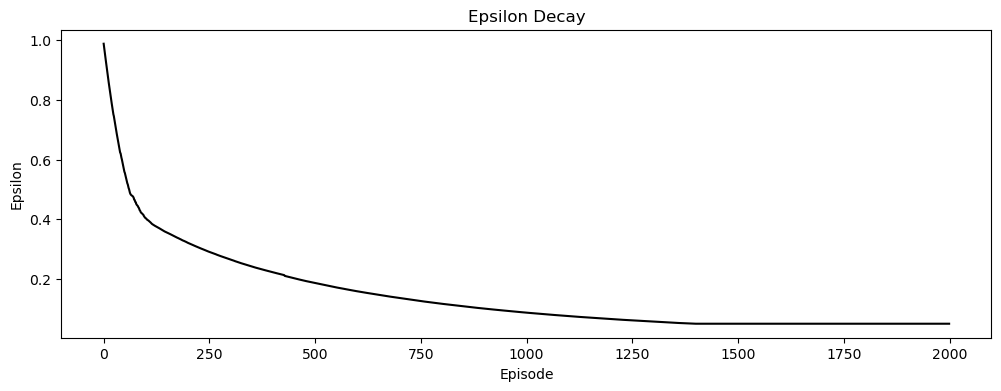

In [10]:
from matplotlib import pyplot as plt

# 绘制奖励变化图
plt.figure(figsize=(12, 4))
plt.plot(rewards_history, color="black")
plt.title('Total Reward per Episode')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()   # REVIEW: 导出为py文件, 改成plt.savefig("01_rewards_history.png")

# 绘制每回合所花费的步数
plt.figure(figsize=(12, 4))
plt.plot(steps_history, color="black")
plt.title('Steps per Episode')
plt.xlabel('Episode')
plt.ylabel('Step')
plt.show()   # REVIEW: 导出为py文件, 改成plt.savefig("02_steps_per_episode.png")

# 绘制损失变化图
plt.figure(figsize=(12, 4))
plt.plot(loss_history, color="black")
plt.title('Training Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')
plt.show()   # REVIEW: 导出为py文件, 改成plt.savefig("03_loss_per_episode.png")

# 绘制epsilon变化图
plt.figure(figsize=(12, 4))
plt.plot(epsilon_history, color="black")
plt.title('Epsilon Decay')
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.show()   # REVIEW: 导出为py文件, 改成plt.savefig("04_epsilon_decay.png")

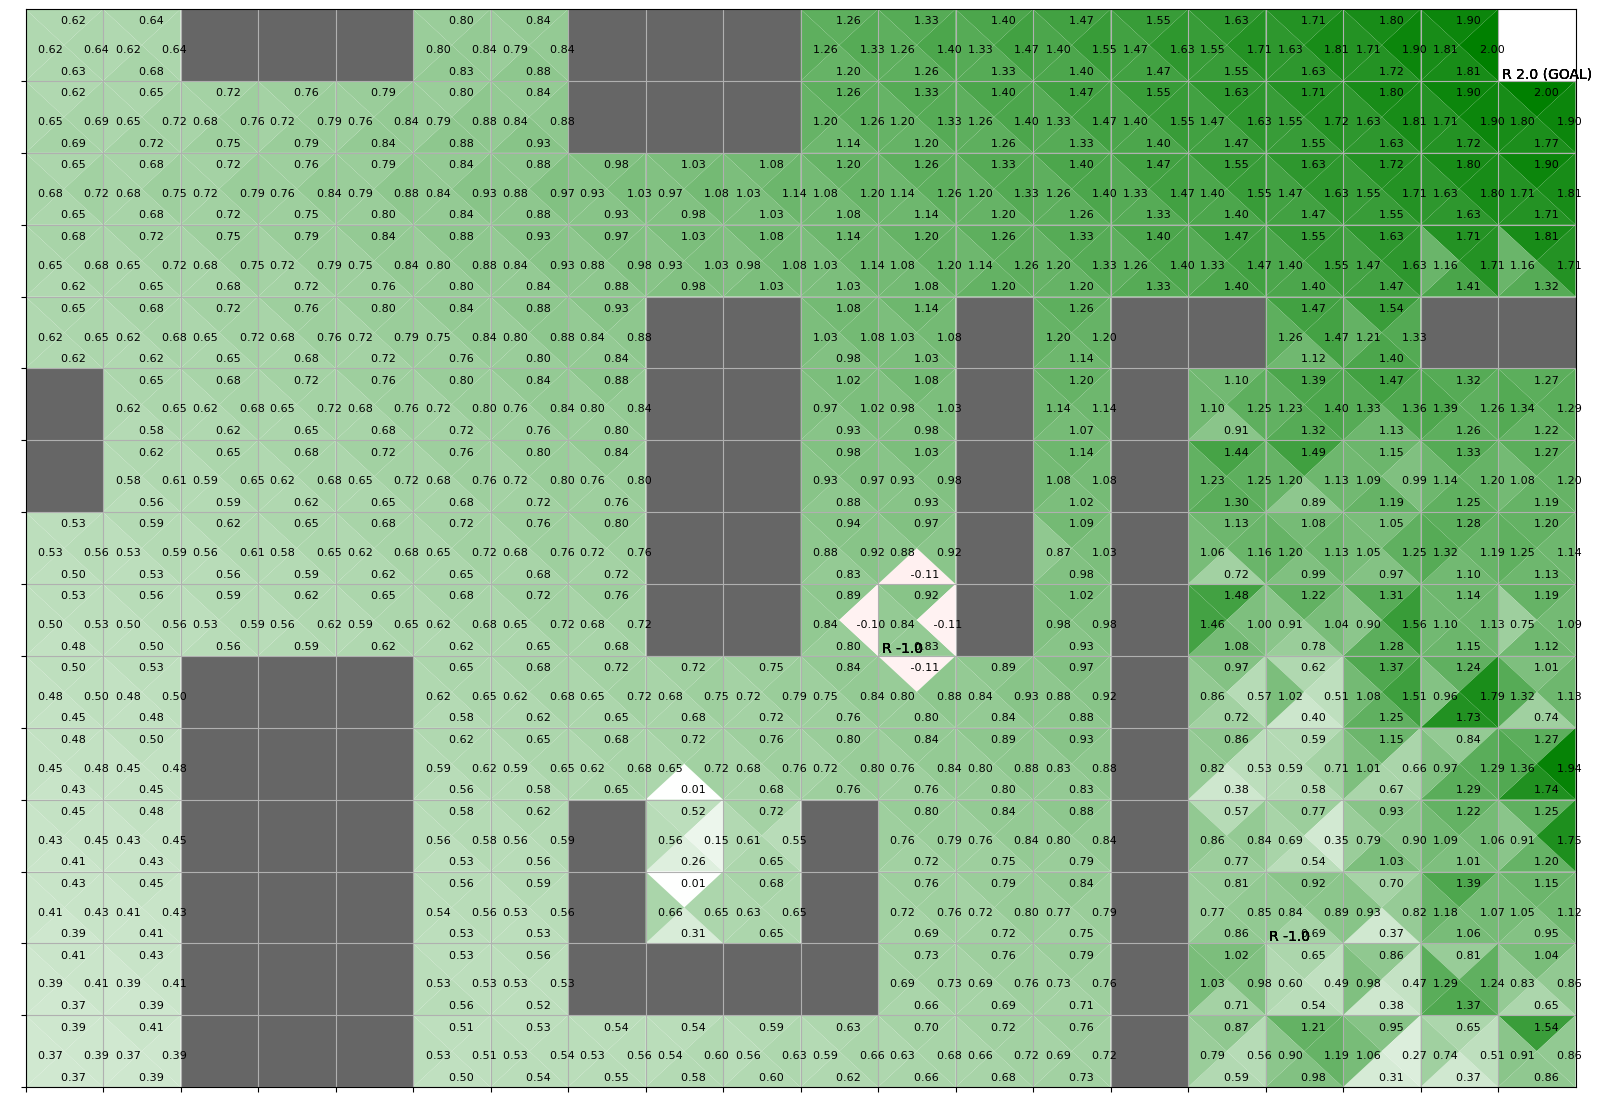

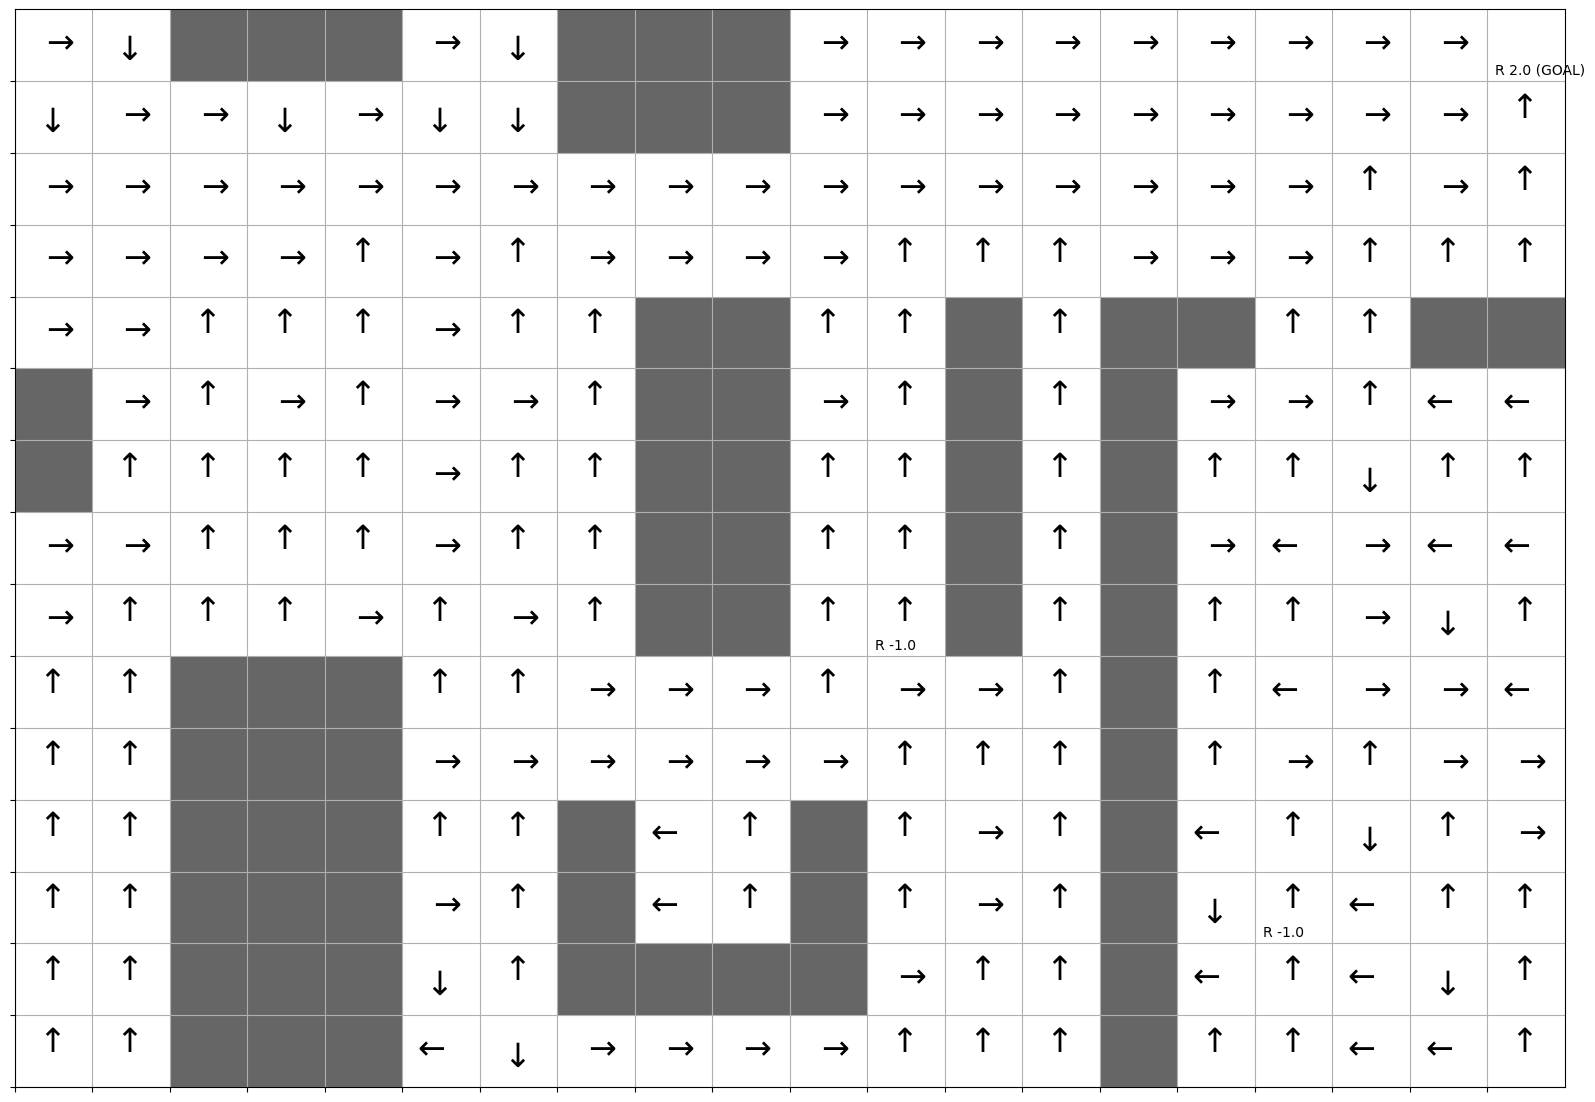

In [11]:
Q = {}

# 获取所有可能的状态
for state in env.states():
    # 跳过墙壁状态
    if state in env.wall_state:
        continue
    # 计算增强编码的状态
    encoded_state = enhanced_one_hot_encode(state, height, width, env.goal_state)
    # 转换为Tensor并移动到正确设备
    state_tensor = torch.FloatTensor(encoded_state).to(agent.device)
    # 获取该状态下的所有动作Q值
    with torch.no_grad():
        q_values = agent.online_net(state_tensor).cpu().numpy()
    # 存储所有动作的Q值
    for action in range(agent.action_dim):
        Q[(state, action)] = q_values[action]

# 渲染Q值
env.render_q(Q)

In [15]:
# 载入保存的模型
checkpoint = torch.load(
    os.path.join(traning_data_root, 'dqn_gridworld_model_final.pth'),
    weights_only=False  # 显式允许完整反序列化
)
agent.online_net.load_state_dict(checkpoint['online_net_state_dict'])
agent.target_net.load_state_dict(checkpoint['target_net_state_dict'])
agent.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
agent.epsilon = checkpoint['epsilon']

# 测试函数
def test_policy(env, agent, height, width, num_tests=1000):
    steps_count = list()
    max_step = 50
    success_count = 0
    for i in range(num_tests):
        raw_state = env.reset()
        state = enhanced_one_hot_encode(raw_state, height, width, env.goal_state)
        done = False
        step_count = 0
        while not done and step_count < max_step:
            action = agent.get_action(state)
            raw_next_state, reward, done = env.step(action)
            next_state = enhanced_one_hot_encode(raw_next_state, height, width, env.goal_state)
            
            state = next_state
            step_count += 1

            if done and reward > 0:
                success_count += 1
                steps_count.append(step_count)
                break
    
    avg_step = np.mean(steps_count)

    print(f"\nSuccess rate: {success_count/num_tests:.2%}")
    return success_count/num_tests, avg_step

# 测试训练好的策略
succ_rate, avg_step = test_policy(env, agent, height, width)
print("模型完成率: ", succ_rate, "平均完成步数: ", avg_step)


Success rate: 100.00%
模型完成率:  1.0 平均完成步数:  34.718
